In [2]:
#TOPIC1_package
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import math
import copy


索引：本文章分为四个topic：
topic1：实现transformer的底层逻辑代码;
topic2：讲解代码;
topic3：基于CCV2021论文的随机丢弃注意力图的多注意丢弃算法，提出TranSER，用于解决transformer在FER中可能会出现的局部块不可见的现象；
topic4：讲讲LBP 与LBP - TOP；
topic5：Task sheet

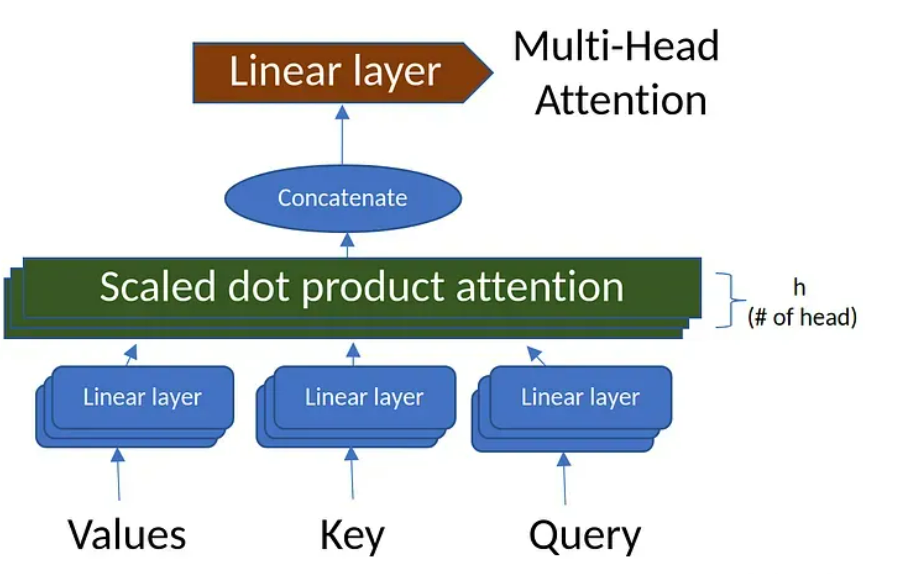

Query，Key，Value的概念取自于信息检索系统，举个简单的搜索的例子来说。当你在某电商平台搜索某件商品（学生冬季蓝色长款羽绒服）时，你在搜索引擎上输入的内容便是Query，然后搜索引擎根据Query为你匹配Key（例如商品的种类，颜色，描述等），然后根据Query和Key的相似度得到匹配的内容（Value)。

让我们进入正题。首先讲讲自注意力机制(self-attention)，由Bengio团队与2014年提出，并在近年广泛的应用在深度学习中的各个领域，例如在计算机视觉方向用于捕捉图像上的感受野，或者NLP中用于定位关键token或者特征。Transformer中抛弃了传统的CNN和RNN，整个网络结构完全是由attention机制组成。更准确的讲，Transformer由且仅由self-attention和Feed Forward Neural Network组成，一个基于transformer的可训练的神经网络可以通过堆叠transformer的形式进行搭建。

如何计算自注意力？第一步是从每个编码器的输入向量创建三个向量Q、K、V（在这种情况下，每个词的嵌入）。因此，对于每个单词，我们创建一个查询向量Q、一个键向量K和一个值向量V。这些向量是通过将嵌入乘以我们在训练过程中训练的三个矩阵来创建的。

注意这些新向量Q、K、V的维度小于嵌入向量。它们的维数为 64，而嵌入和编码器输入/输出向量的维数为 512。它们不必更小，这是使注意力（大部分）的计算保持不变的架构选择。
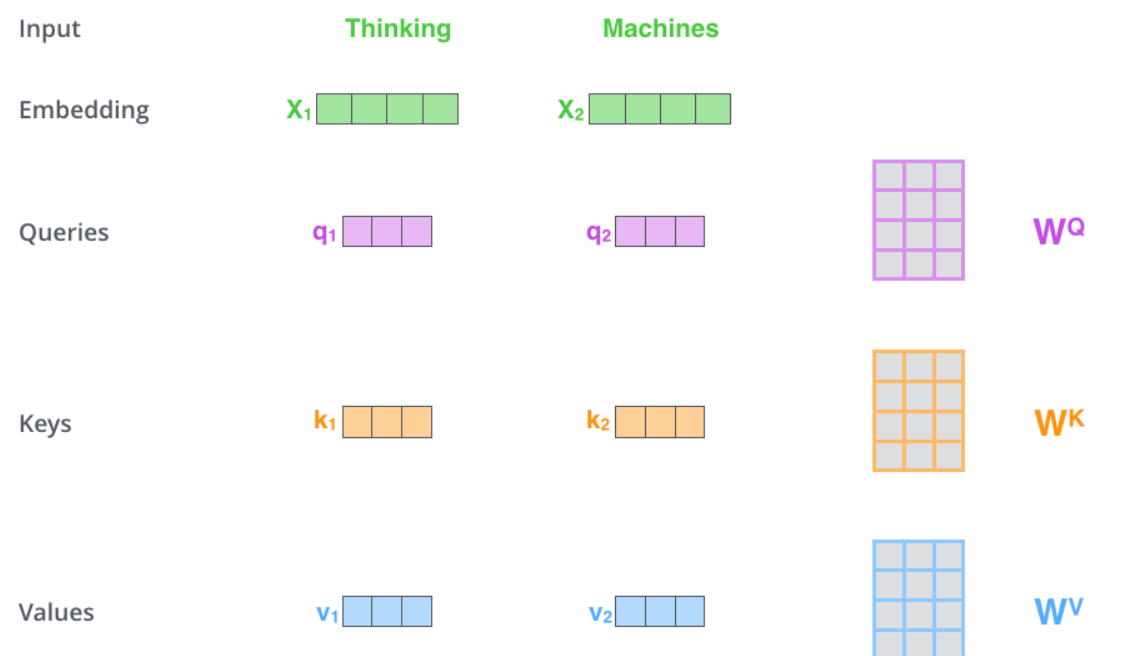
将x 1 x_1x 
1
​
  乘以W Q W^QW 
Q
 权重矩阵会产生q 1 q_1q 
1
​
  ，即与该词关联的“查询”向量。我们最终为输入句子中的每个单词创建了一个“查询Q”、一个“键K”和一个“值V”投影。
让我们顺着前文提到的Query，key与value继续解释，它们是用于计算和思考注意力的抽象概念。

计算self-attention的第二步是计算一个分数。假设我们正在计算本例中第一个单词“Thinking”的自注意力。我们需要根据这个词对输入句子的每个词进行评分。当我们在某个位置对单词进行编码时，分数决定了对输入句子其他部分的关注程度。

分数是通过查询向量与我们正在评分的各个单词的关键向量的点积来计算的。因此，如果我们正在处理位置#1中单词的自注意力，第一个分数将是q 1 q_1q 
1
​
 和k 1 k_1k 
1
​
 的点积。第二个分数是q 2 q_2q 
2
​
 和k 2 k_2k 
2
​
 的点积。


第三步和第四步是将分数除以 8（论文中使用的关键向量维度的平方根 64。这会导致梯度更稳定。这里可能还有其他可能的值，但这是默认），然后通过 softmax 操作传递结果。Softmax 将分数归一化，因此它们都是正数并且加起来为 1。

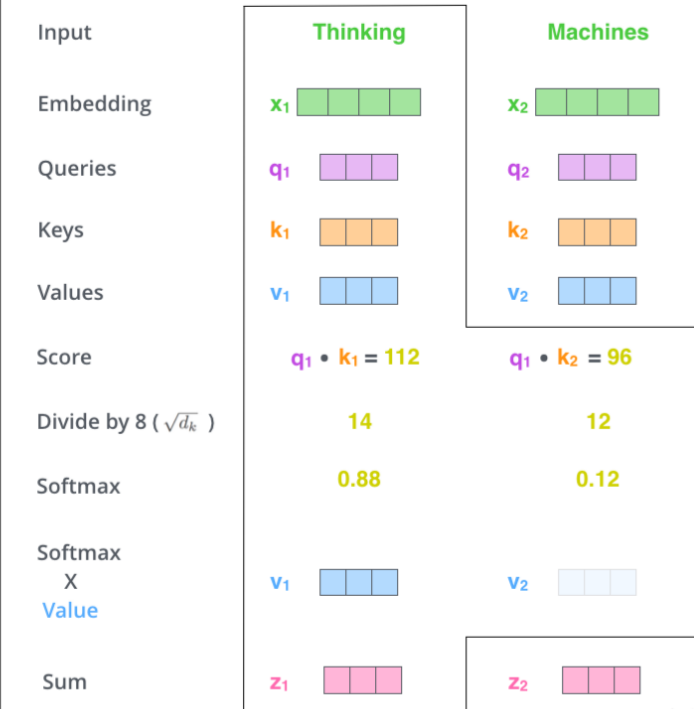

至此自注意的计算结束，结果应该是一个可被发送至前馈神经网络的向量。然而在现实中自注意力的计算是通过矩阵进行的，使用矩阵计算可获得更快的速度

下面讲讲关于使用矩阵进行自注意力的计算（可跳）

第一步是计算查询Q、键K和值V矩阵。我们通过将嵌入打包到矩阵X中，并将其乘以我们训练的权重矩阵（W Q W^QW 
Q
 、W K W^KW 
K
 、W V W^VW 
V
 ）来做到这一点。


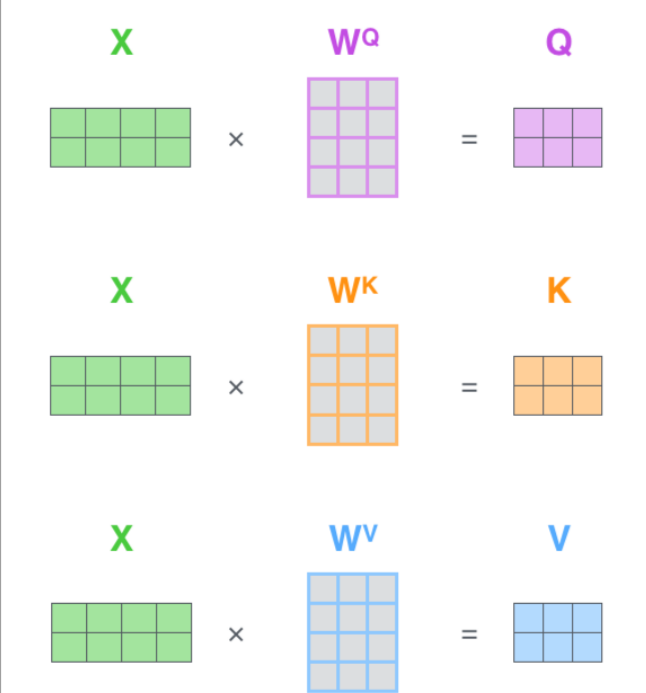

X矩阵 中的每一行对应于输入句子中的一个单词。我们再次看到嵌入向量（512，或图中 4 个框）和 q/k/v 向量（64，或图中 3 个框）大小的差异

最后，由于我们处理的是矩阵，我们可以将步骤二到六合一公式来计算自注意力层的输出。

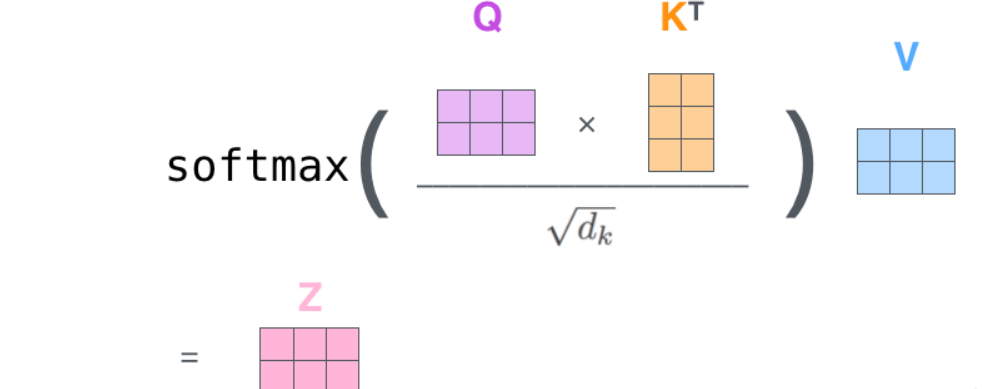

下面讲讲多头注意力机制（multiple-attention）

多头注意力与单头注意力(self-attention)最大的区别从名字上便可得知，multiple-attention将输入序列拆分为多个子空间（理解为重复进行多次运算也可，两者并不存在太大的差别。transformer是并行运算最华丽的一种体现。这点我查阅了多篇论文都存在争议，不过原文作者是写成了拆分），然后在每个子空间中独立的计算权重，最后将结果拼接。相较于self-attention，multiple-attention可以获取更多的上下文信息(进行更多次的运算）

当然，这么做也存在着弊端——在FER中，multiple-attention的多头机制会干扰识别模型对于面部特征点的获取，导致局部块被忽略（为什么会出现这种情况呢，因为权重的不同，会影响模型对于最相似的特征的判断，从而忽略其他部分）

通过多头注意力，我们为每个头维护单独的 Q/K/V 权重矩阵，从而产生不同的 Q/K/V 矩阵。正如我们之前所做的那样，我们将 X 乘以W^Q
 /W^K 
 /W^V 
  矩阵以产生 Q/K/V 矩阵。

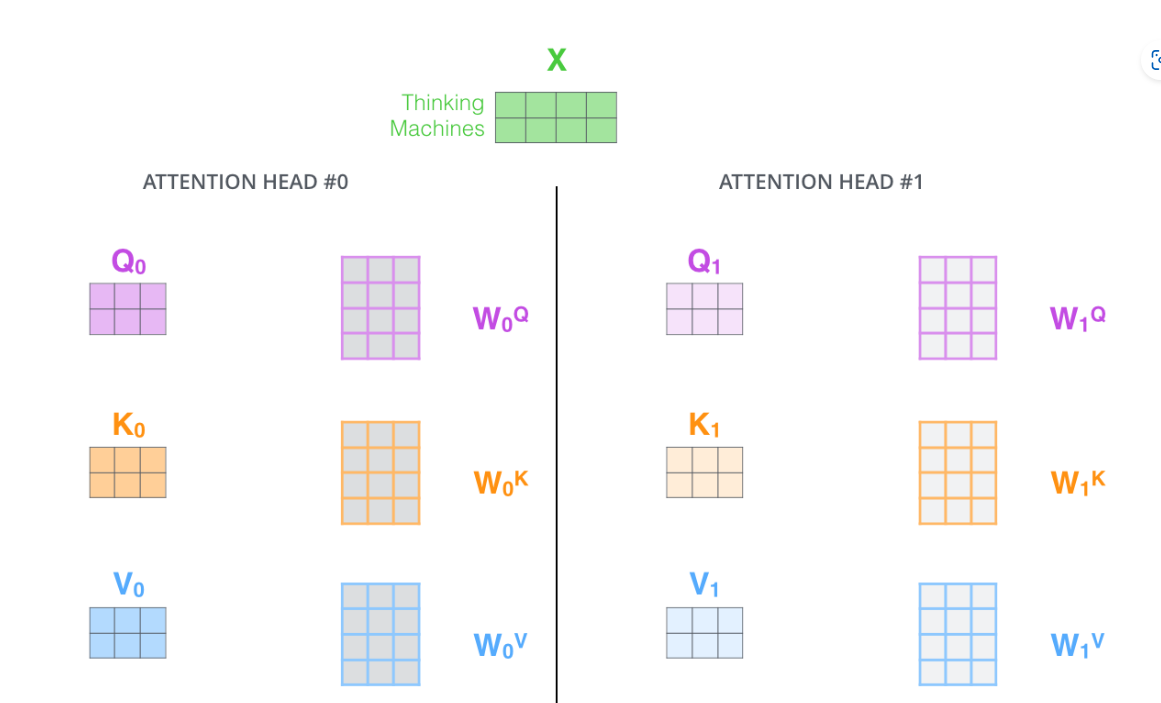

如果我们进行与上述相同的自注意力计算，只是使用不同的权重矩阵进行八次不同的计算，我们最终会得到八个不同的 Z 矩阵


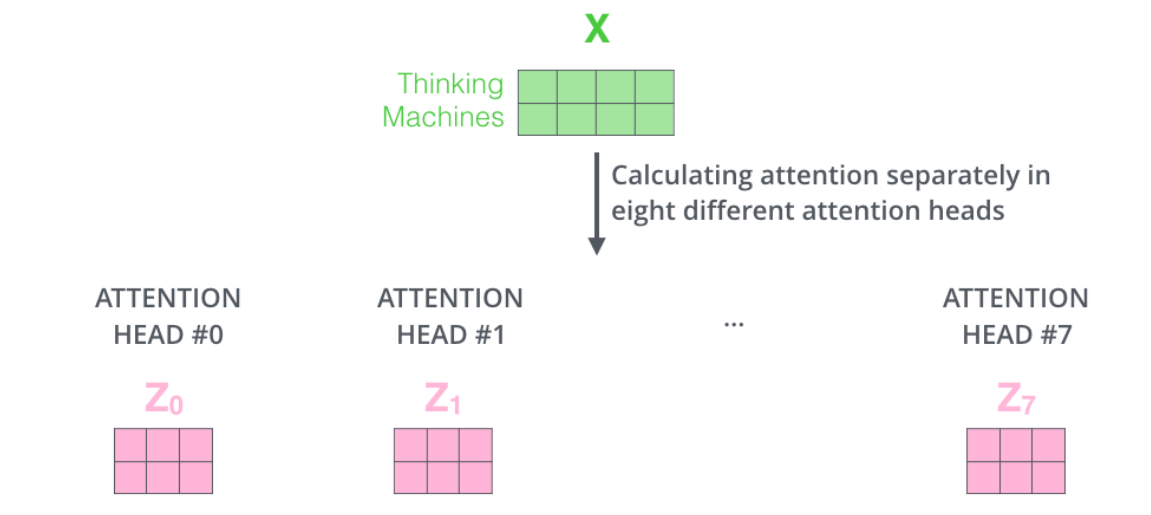

这给我们带来了一些挑战。前馈层不需要八个矩阵——它需要一个矩阵（每个单词的向量）。所以我们需要一种方法将这八个Concatenate浓缩成一个矩阵。

我们如何做到这一点？我们连接这些矩阵，然后将它们乘以一个额外的权重矩阵W^O 
。

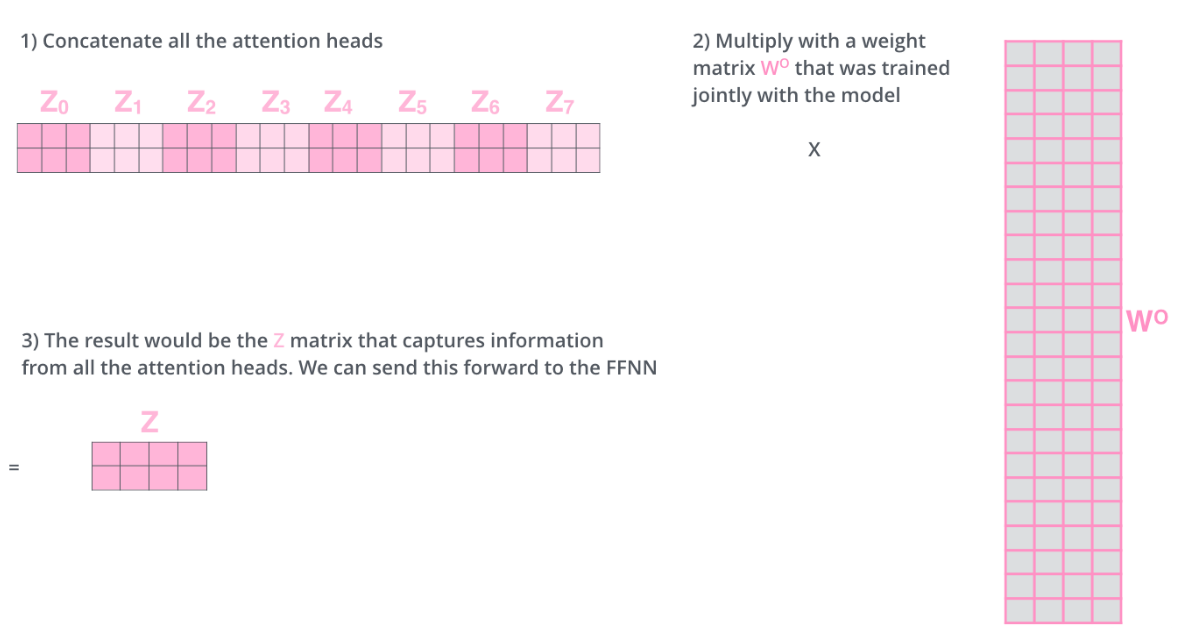

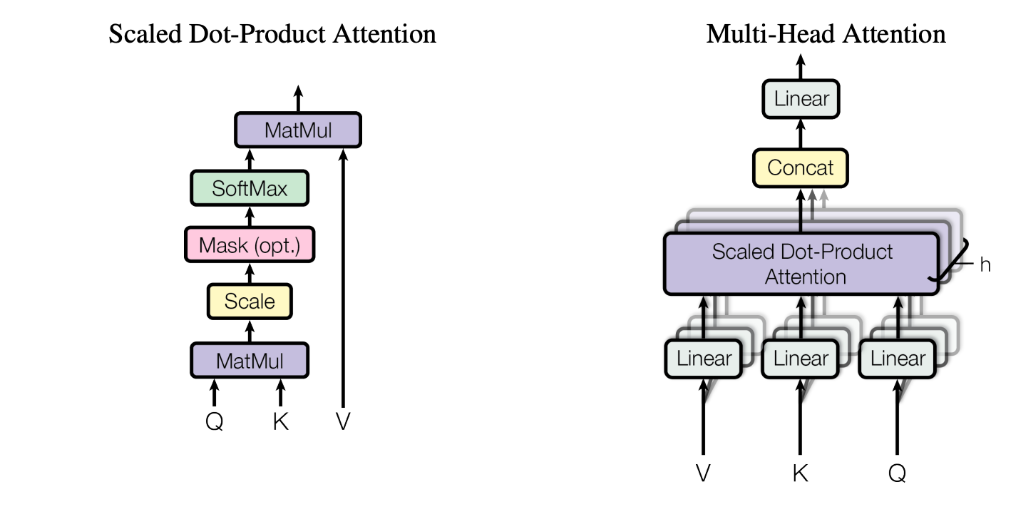

实现代码如下

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):#d_model:模型维度；num_head：注意力头的数量
        super(MultiHeadAttention, self).__init__()
        #断言
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        #定义四个线性层用于查询Query，Key，Value和Output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        #实现缩放点积注意力机制
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
        #转换张量
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
        #split_heads的逆操作，将张量还原，便于固定统一维度
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output


MultiHeadAttention 代码使用输入参数和线性变换层初始化模块。它计算注意力分数，将输入张量重塑为多个头，并组合所有头的注意力输出。前向方法计算多头自注意力，使模型能够关注输入序列的某些不同方面。

位置式前馈神经网络(PositionWiseFeedforward Network，下面简称为PFN)
与普通的FNN不同，PFN引入了位置编码用于实现对于序列信息的处理（普通网络都不具备处理序列的能力，即具有顺序的信息）,
它接受一个形状为（batch_size，seq_length, feature_size）的三维张量。Position-wise FFN由两个全连接层组成，他们作用在最后一维上。因为序列的每个位置的状态都会被单独地更新，所以我们称他为position-wise，这等效于一个1x1的卷积。

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


PFN类扩展了 PyTorch 的 nn.Module 并实现了位置前馈神经网络。该类使用两个线性变换层和一个 ReLU 激活函数进行初始化。前向方法依次应用这些变换和激活函数来计算输出。此过程使模型能够在进行预测时考虑输入元素的位置。

位置编码：位置编码用于注入输入序列中每个标记的位置信息。它使用不同频率的正弦和余弦函数来生成位置编码。

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


PositionalEncoding 类使用输入参数 d_model 和 max_seq_length 进行初始化，创建一个张量来存储位置编码值。该类根据缩放因子 div_term 分别计算偶数和奇数索引的正弦和余弦值。前向方法通过将存储的位置编码值添加到输入张量来计算位置编码，从而使模型能够捕获输入序列的位置信息。


编码层的构建：
编码器层由多头注意力层、位置前馈层和两个层归一化层组成。

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


EncoderLayer 类使用输入参数和组件进行初始化，包括 MultiHeadAttention 模块、PositionWiseFeedForward 模块、两层归一化模块和 dropout 层。前向方法通过应用自注意力、将注意力输出添加到输入张量并对结果进行归一化来计算编码器层输出。然后，它计算位置前馈输出，将其与归一化的自注意力输出相结合，并在返回处理后的张量之前对最终结果进行归一化。

解码器层由两个多头注意力层、一个位置前馈层和三个层归一化层组成。

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


DecoderLayer 使用输入参数和组件进行初始化，例如用于屏蔽自注意力和交叉注意力的 MultiHeadAttention 模块、PositionWiseFeedForward 模块、三层归一化模块和 dropout 层。

前向方法通过执行以下步骤来计算解码器层输出：

计算屏蔽自注意力输出并将其添加到输入张量，然后进行 dropout 和层归一化。
计算解码器和编码器输出之间的交叉注意力输出，并将其添加到归一化屏蔽自注意力输出中，然后进行 dropout 和层归一化。
计算位置前馈输出并将其与归一化交叉注意力输出相结合，然后进行 dropout 和层归一化。
返回处理后的张量。
这些操作使解码器能够基于输入和编码器输出生成目标序列。


将编码器与解码器合并，实现完整版的transformer模型

In [ ]:
class Transformer(nn.Module):
    #src_vocab_size与tgt_vocab_size表示需要接收的信息
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        #generate_mask类用于生成源序列和目标序列的掩码。掩码在注意力机制中用于忽略填充和未来的位置
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)#src_mask是一个2D掩码，用于在编码器中忽略填充
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)#tgt_mask是一个3D掩码，用于在解码器中忽略填充和未来的位置
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output


TOPIC3：关于transformer架构与FER(Facial-emotion-recognition)

首先聊聊关于Tran-FER的一些背景。目前大多数的方法仍在使用手工特征与浅层学习(eg:LBP,LBP-TOP,非矩阵负分解与稀疏学习），然而近年来，随着大量识别竞赛的出现与识别难度的提高，以及良好的数据样本的提供，深度学习在这方面的优势开始逐渐体现出来

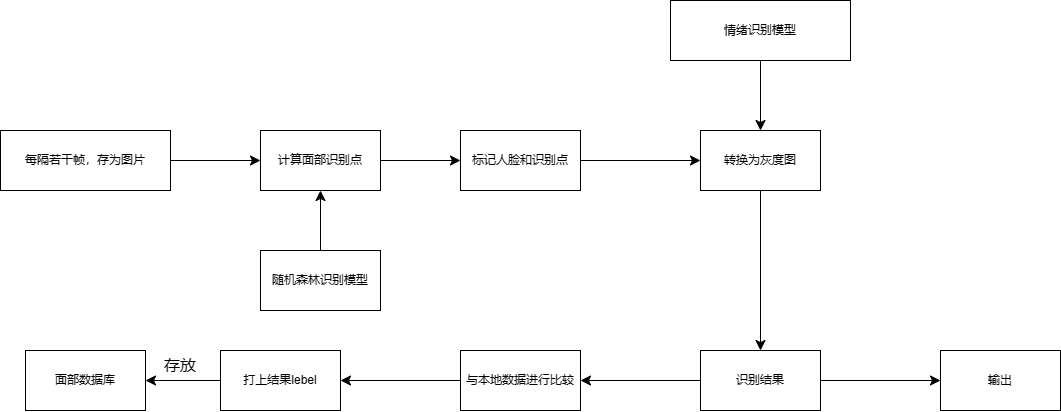

reference list：Attention is all you need
A. Vaswani, N. Shazeer, N. Parmar, J. Uszkoreit, L. Jones, A. Gomez, {. Kaiser, and I. Polosukhin. Advances in Neural Information Processing Systems , page 5998–6008. (2017)

Github：https://github.com/riannyway